# 1. install dependancies


##  1.1 Install dependancies

In [1]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

## 1.2  import dependancies

In [2]:
# import new
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [3]:
# import tensorflow functional API
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models  import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

## Set GPU growth

## 1.4 Create Folder Structure

In [4]:
#set-up paths
POS_PATH = os.path.join ('data' , 'positive')
NEG_PATH = os.path.join ('data' , 'negative')
ANC_PATH = os.path.join ('data' , 'anchor')

In [ ]:
# make directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect positive and Anchors

## 2.1 untar labelled faces in the wild dataset

In [5]:
# http://vis-www.cs.umass.edu/lfw/

In [6]:
# uncompress the tar GZ labbelled faces in the wild
!tar -xf lfw.tgz

In [7]:
# move lfw images to the negative directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join (NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)
        

## 2.2 Collect positive  and anchor classes

In [8]:
# unique identifier
import uuid

In [9]:
#Access open cv webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): # while the camera is open loops through all the frames on the camera
    ret, frame = cap.read() 
    
#   cut down to 250 :250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    # collect anchors 
    if cv2.waitKey(1) & 0XFF==ord('a'):
        # create a unique file path
        imgname = os.path.join(ANC_PATH, "{}.jpg".format(uuid.uuid1()))
        #write out our anchor image 
        cv2.imwrite(imgname, frame)

    
    # collect positives
    if cv2.waitKey(1) & 0XFF==ord('p'):
        # create a unique file path
        imgname = os.path.join(POS_PATH, "{}.jpg".format(uuid.uuid1()))
        #write out our pasitive image 
        cv2.imwrite(imgname, frame)
    
    #show image back to screen 
    cv2.imshow('Image Collection', frame)
    
    #breaking gracefully 
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
    
# release the webcam 
cap.release()
# close the image show frame
cv2.destroyAllWindows()

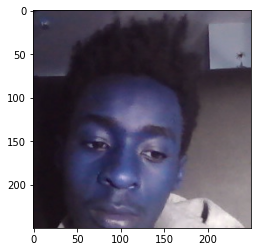

In [11]:
plt.imshow(frame)

# 3. Load and preprocess images

## 3.1 Get image directories

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300) 

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
dir_test.next()

b'data\\anchor\\90f9740b-37a5-11ec-a5bf-58961dfe2d14.jpg'

## 3.2 Preprocess Scale and resize

In [15]:
def preprocess (file_path):
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    
    # load in image in tf.io 
    img = tf.io.decode_jpeg(byte_img)
    
    # preprocessing steps. - resize image
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [16]:
img = preprocess('data//anchor/84167eb2-37a5-11ec-bc36-58961dfe2d14.jpg')

In [17]:
img.numpy().min()

0.05514706

In [18]:
img.numpy().max()

1.0

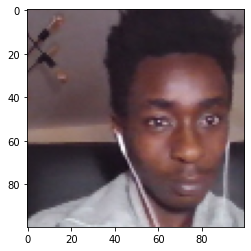

In [19]:
plt.imshow(img)

In [20]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

## 3.3 Create labelled dataset

In [21]:
# (anchor, positive) ==> 1,1,1,1,1
# (anchor, negative) ==> 0,0,0,0,0

# tf.ones_like([4.4343,1,14.4343,4.2343])

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [23]:
samples = data.as_numpy_iterator()

In [24]:
example = samples.next()

In [25]:
example

(b'data\\anchor\\90f500a0-37a5-11ec-932a-58961dfe2d14.jpg',
 b'data\\positive\\a01567d5-37a5-11ec-9ecf-58961dfe2d14.jpg',
 1.0)

## 3.4 Build Train and test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*example)

In [28]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take (round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model engineering

## 4.1 Build Embending Layer

In [31]:
# inp = Input(shape=(100,100,3), name = "input_name")
    
# # first block
# c1 = Conv2D(64, (10, 10), activation='relu')(inp)
# m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

# #second block
# c2 = Conv2D(128, (7, 7), activation='relu')(m1)
# m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

# #third block
# c3 = Conv2D(128, (4, 4), activation='relu')(m2)
# m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

# #final embending block
# c4 = Conv2D(256, (4, 4), activation='relu')(m3)
# f1 = Flatten()(c4)
# d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = "input_name")
    
    # first block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    #second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    #third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    #final embending block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    
    
    return  Model(inputs = [inp] , outputs = [d1], name = 'embedding')

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_name (InputLayer)      [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [35]:
# siemece L1 Distance layer 
class L1Dist(Layer):
    
    #init method inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # magic - similarity calculation
    def call (self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

## 4.3 Make siemese model

In [37]:
def make_siamese_model():
    
    # handle anchor inputs
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # handle anchor inputs
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # calssification Layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

# 5. Model definition

## 5.1 Set up a Loss Function and  Optimizer

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Checkpoints

In [42]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

## 5.3 Build a Custom Training Step

In [43]:
@tf.function
def train_step(batch):
    
    # record all of our loss
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image
        X = batch[:2]
        # get label
        y = batch[2] 
        
        # forward pass
        yhat = siamese_model(X, training=True)
        # calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    #calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

## 5.4 Create a training loop

In [44]:
def train(data, EPOCHS):
    #  loop through the epochs
    for epoch in range(1, EPOCHS+1):
        print ('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx,batch in enumerate(data):
            
            # train step
            train_step(batch)
            progbar.update(idx+1)
            
        #save checkpoints.
        if epoch % 2 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
    


## 5.5 Train the MODEL

In [57]:
EPOCHS = 5

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/5
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 8/27 [=======>......................] - ETA: 12:31

# 6 Evaluate Model

## 6.1 Import metrics

In [45]:
# import metric calculation
from tensorflow.keras.metrics import Precision, Recall

 ## 6.2 Make predictions

In [46]:
# get a batch of test data 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [47]:
# Make Predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.50030255],
       [0.5000919 ],
       [0.5022757 ],
       [0.50224096],
       [0.50172997],
       [0.5009923 ],
       [0.50094175],
       [0.5028584 ],
       [0.50194716],
       [0.50160223],
       [0.50094014],
       [0.5004234 ],
       [0.5008506 ],
       [0.5013603 ],
       [0.5008668 ],
       [0.50121796]], dtype=float32)

In [48]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [49]:
y_true

array([1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

## 6.3 Calculate metrics

In [50]:
# create a metric object
m = Recall()

# calculate the recall value
m.update_state(y_true, y_hat)

# Return Recal result
m.result().numpy()

1.0

In [51]:
# create a metric object
m = Precision()

# calculate the precison value
m.update_state(y_true, y_hat)

# Return precision result
m.result().numpy()

0.625

## 6.4 viz results

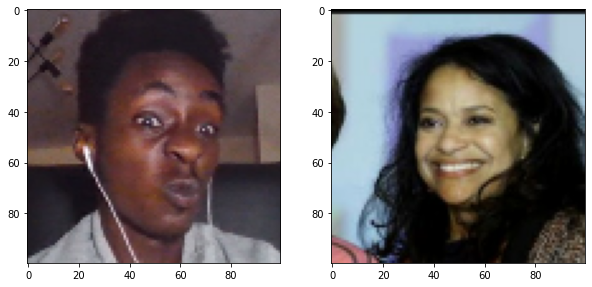

In [52]:
# plot figure size
plt.figure(figsize = (10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# second subplot
plt.subplot (1,2,2)
plt.imshow(test_val[4])
plt.show()

# 7. Save model

In [53]:
# save weights
siamese_model.save('siamesemodel.h5')

In [54]:
# reload model
model  = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [55]:
# Make predictions through loaded model 
model.predict([test_input, test_val])

array([[0.50030255],
       [0.5000919 ],
       [0.5022757 ],
       [0.50224096],
       [0.50172997],
       [0.5009923 ],
       [0.50094175],
       [0.5028584 ],
       [0.50194716],
       [0.50160223],
       [0.50094014],
       [0.5004234 ],
       [0.5008506 ],
       [0.5013603 ],
       [0.5008668 ],
       [0.50121796]], dtype=float32)

In [63]:
# reloaded summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real time test 

## 8.1 Verification function

In [96]:
def verify(model, detection_threshold, verification_threshold):
    # build result array
    results = []
    
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        
        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

        
    #detection threshold = metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    #verification threshold = propotion of positive predictions/total positve samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    return results, verified

## 8.2  OpenCV real time

In [98]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    # cut down to 250 :250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow("Verification", frame)
    
    # Verification trigger
    if cv2.waitKey(1) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
    
    #Run verification
#     results, verified = verify(model, 0.6, 0.7)
#     print (verified)
    
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()


In [ ]:
np.sum(np.squeeze(results) > 0.9)